In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(suppress=True)

In [2]:
###########################################################################
# Code (START)                                                            #
###########################################################################
def exp_file_write(file_path, input_str, open_mode="a"):
    with open(file_path, open_mode) as f:
        f.write(input_str)

def consolidate_efx_files(i_path_to_efx_files, nbits=10600, nVMs=10):   
    con_efd_fp = f'{i_path_to_efx_files}/efd_emd_hesstrace_v0-31.log'
    con_efr_fp = f'{i_path_to_efx_files}/efr_emd_hesstrace_v0-31.log'
    exp_file_write(con_efd_fp, "", "w")
    exp_file_write(con_efr_fp, "", "w")  

    for i in range(0, nbits, int(nbits/nVMs)):
        curr_efd_fp = f'{i_path_to_efx_files}/efd_emd_hesstrace_v0-31_b{i}-{int(i+nbits/nVMs)}-forloop.log'
        with open(curr_efd_fp, "r") as c_efd:
            for line in c_efd:
                exp_file_write(con_efd_fp, line)

        curr_efr_fp = f'{i_path_to_efx_files}/efr_emd_hesstrace_v0-31_b{i}-{int(i+nbits/nVMs)}-forloop.log'
        with open(curr_efr_fp, "r") as c_efr:
            for line in c_efr:
                exp_file_write(con_efr_fp, line)

    return con_efd_fp, con_efr_fp

def parse_efr_file(i_efr_fp, nbits=10600, nvals=32, emd_val_dflt=0.0, ht_val_dflt=0.0):
    #S: Prefill emd and ht (hessian trace) dicts
    bi_to_emd  = dict()
    bi_to_ht    = dict()
    for bi in range(nbits):
        bi_to_emd[bi] = [emd_val_dflt for _ in range(nvals)]
        bi_to_ht[bi]  = [ht_val_dflt  for _ in range(nvals)]

    didnt_converge = 0
    htdc = dict()

    #S: For everyline of the efr file
    with open(i_efr_fp, "r") as f:
        for li, line in enumerate(f):
            try:
                #S: Split the string into the (vi,bi), emd , and ht sub strings
                curr_vi_bi, curr_emd, curr_htd = [substr.strip() for substr in line.split("|")]
                vi, bi = [int(val) for val in curr_vi_bi[1:-1].split(",")]
                
                #S: Store the emd value at (vi,bi)
                bi_to_emd[bi][vi] = float(curr_emd)
                
                #S: Store the real hessian trace value (or a default) at (vi,bi)
                if ("'conv2d_0_m':" in curr_htd) and ("'encoded_vector':" in curr_htd):
                    ht_val  = float(curr_htd.split("'conv2d_0_m':")    [1].split(",")[0].strip())
                    ht_val += float(curr_htd.split("'encoded_vector':")[1].split(",")[0].strip())
                    bi_to_ht[bi][vi] = ht_val
                else:
                    didnt_converge +=1
                    try:
                        htdc[bi] += 1 
                    except KeyError:
                        htdc[bi]  = 1

            except ValueError:
                #I: This handles the column header lines
                ### which (vi, bi) | emd | hessian_trace_dictionary  
                pass

    return bi_to_emd, bi_to_ht

def get_wi(i_bi, i_bw):
    return int(i_bi/i_bw)

def get_wbi(i_bi, i_bw):
    return int(i_bi%i_bw)

def get_hmap_intesity_grid(i_bi_to_AgMtrc, wbits=5, agmtrc_dflt=0.0):
    wis  = list()
    bis  = list()
    agmtrc = list()

    for bi in i_bi_to_AgMtrc.keys():
        wis.append(get_wi(bi,5))
        bis.append(get_wbi(bi,5))
        agmtrc.append(i_bi_to_AgMtrc[bi])

    #S: Create intensity matrix/grid based on weight bits
    intensity = list()
    for wi in sorted(list(set(wis))):
        rel_agmtrcs = agmtrc[wi*wbits:(wi+1)*wbits] 
        if len(rel_agmtrcs) < wbits:
            rel_agmtrcs += [agmtrc_dflt for _ in range(wbits-len(rel_agmtrcs))]
        intensity.append(rel_agmtrcs)

    #S: Finalize intensity matrix/grid
    intensity = np.array(intensity).transpose()

    #S: Setup the 2D grid with Numpy
    x = sorted(list(set(wis)))
    y = sorted(list(set(bis)))
    x, y = np.meshgrid(x, y)

    return x, y, intensity

def gen_hmap_from_intensity(i_intensity, i_title, i_save_fp):
    #S: Plot the heatmap and save the file
    fig, ax = plt.subplots(figsize=(22,5))# Sample figsize in inches
    hm_ax = sns.heatmap(i_intensity, annot=False, fmt="f", ax=ax, cmap="viridis_r", square=False, vmin=i_intensity.min(), vmax=i_intensity.max())
    hm_ax.xaxis.tick_bottom()
    hm_ax.yaxis.tick_left()
    hm_ax.set_title(i_title, fontdict={'weight': 'bold'})
    hm_ax.set_xlabel("Weight Index", fontdict={'weight': 'bold'})
    hm_ax.set_ylabel("Bit Index", fontdict={'weight': 'bold'})
    plt.yticks(rotation=0)
    plt.savefig(i_save_fp, bbox_inches="tight")
    plt.show()
###########################################################################
# Code (END)                                                              #
###########################################################################

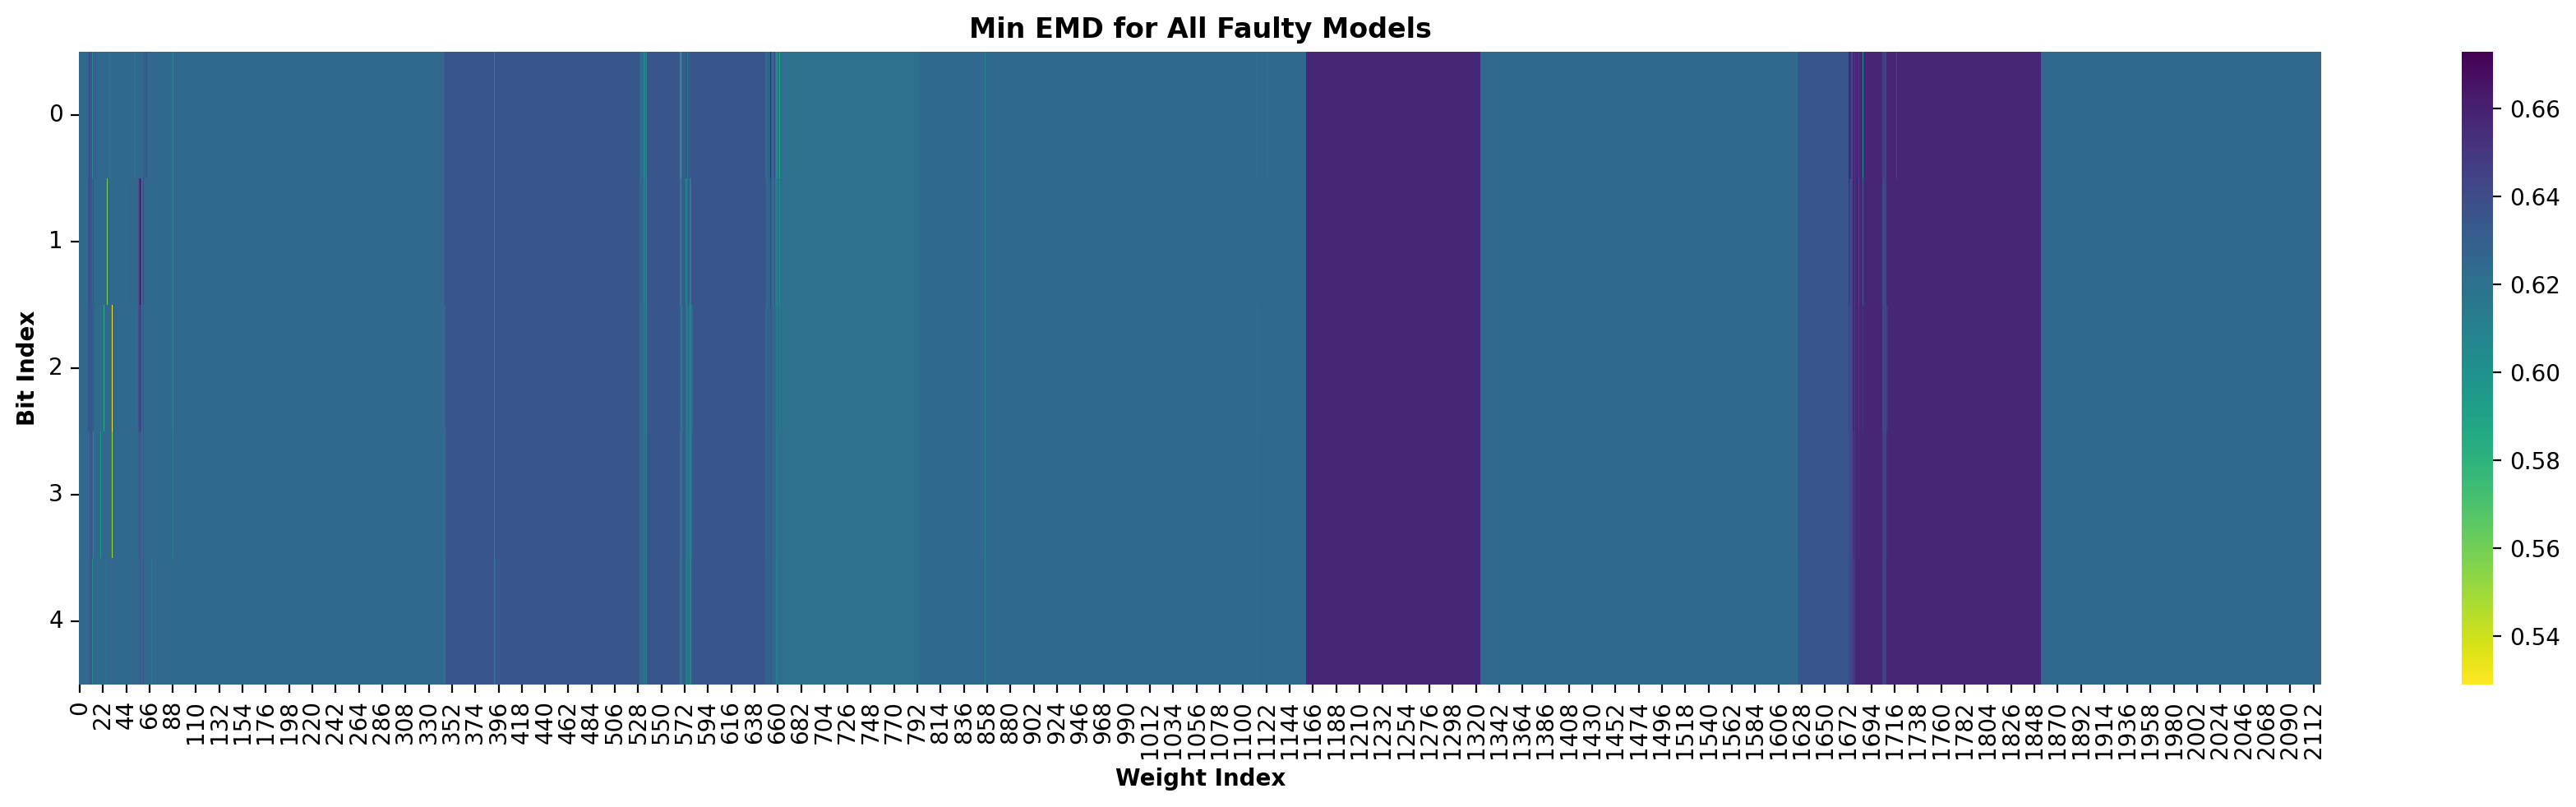

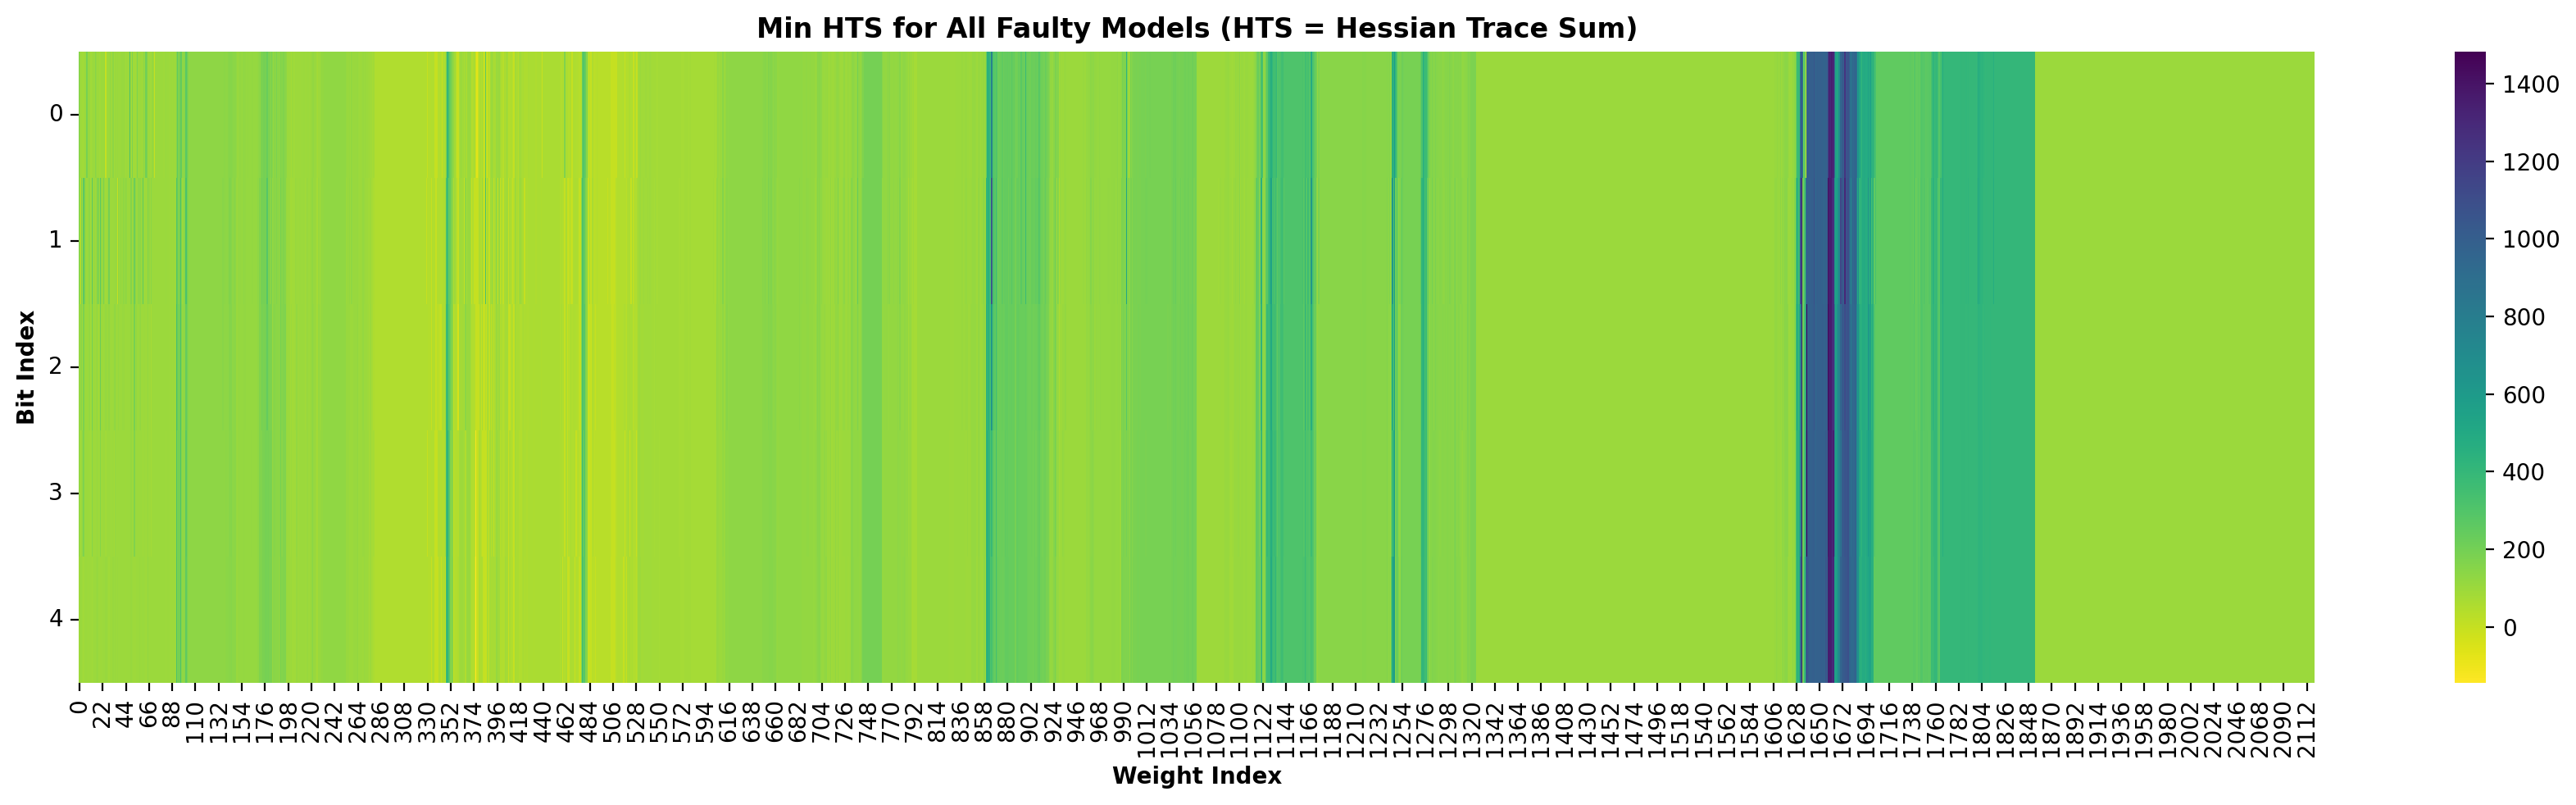

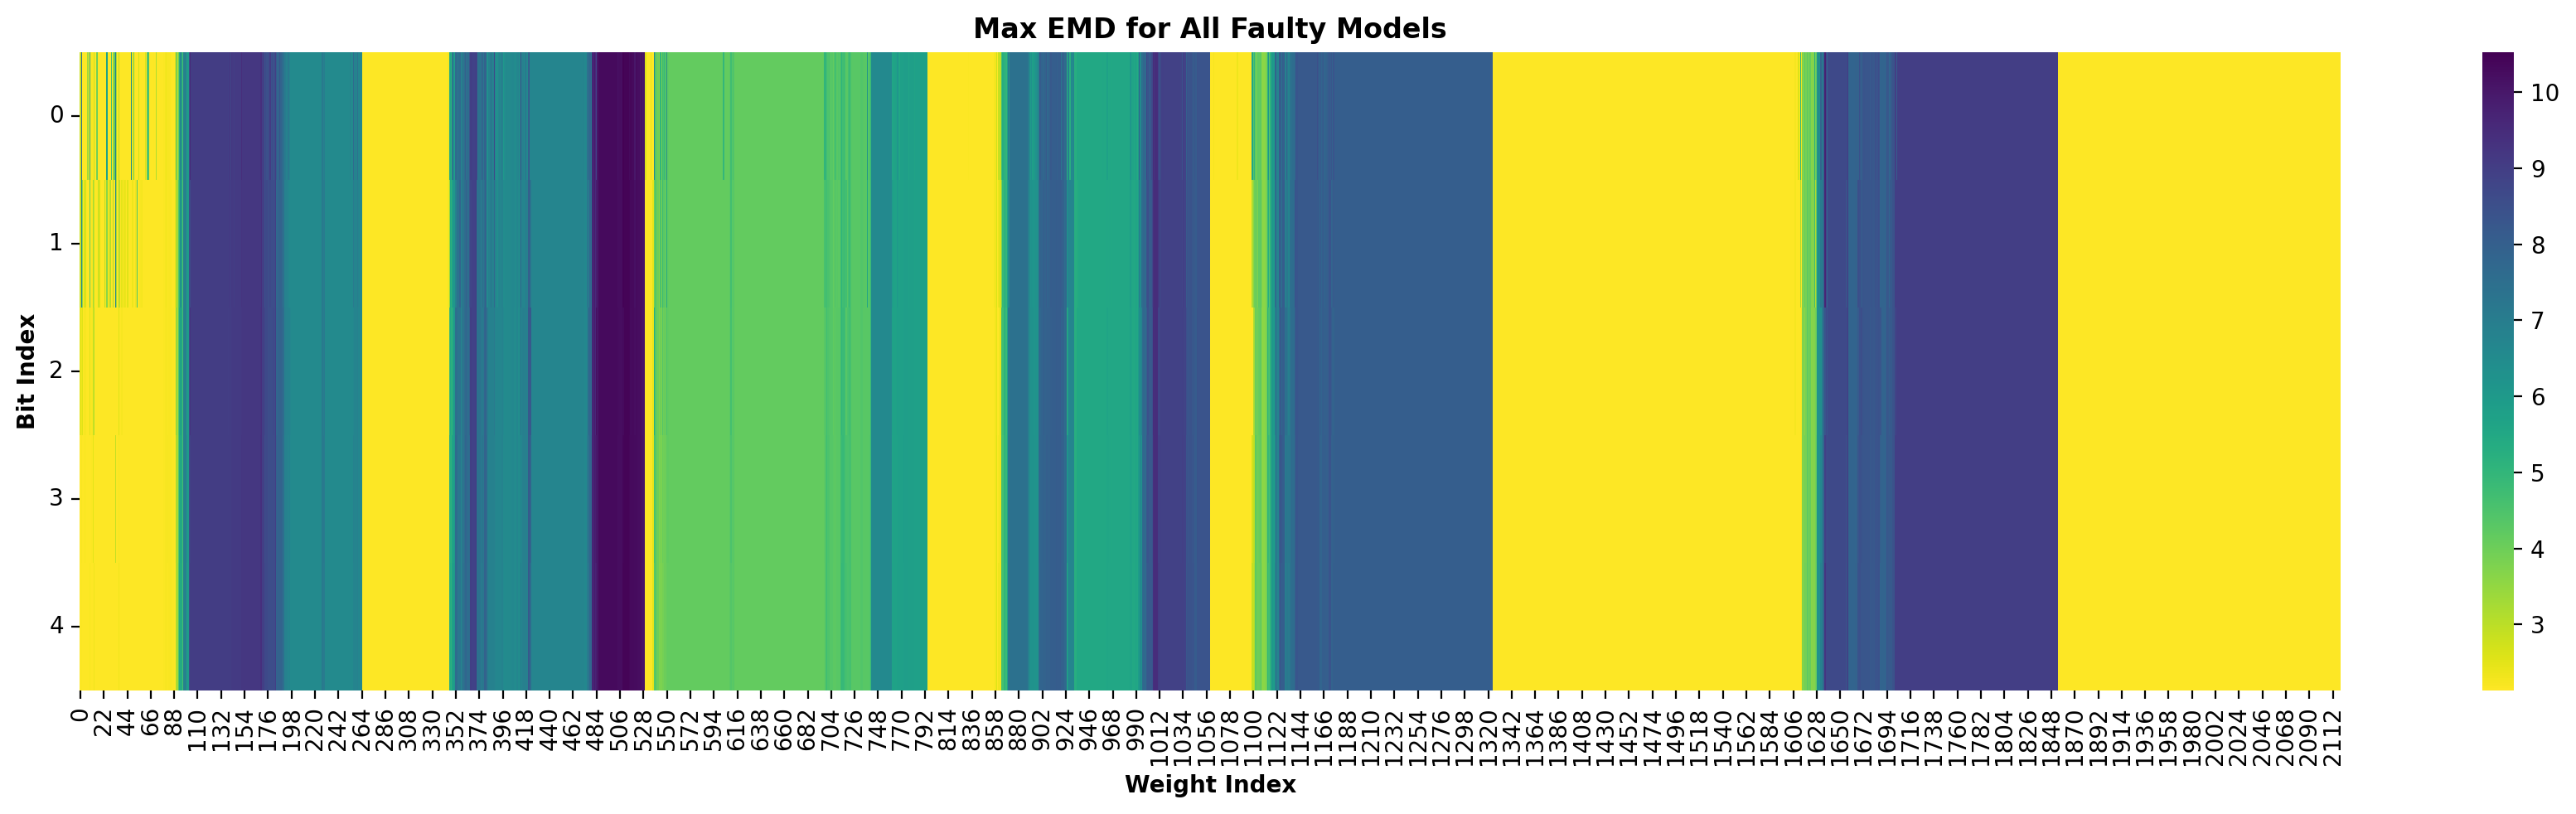

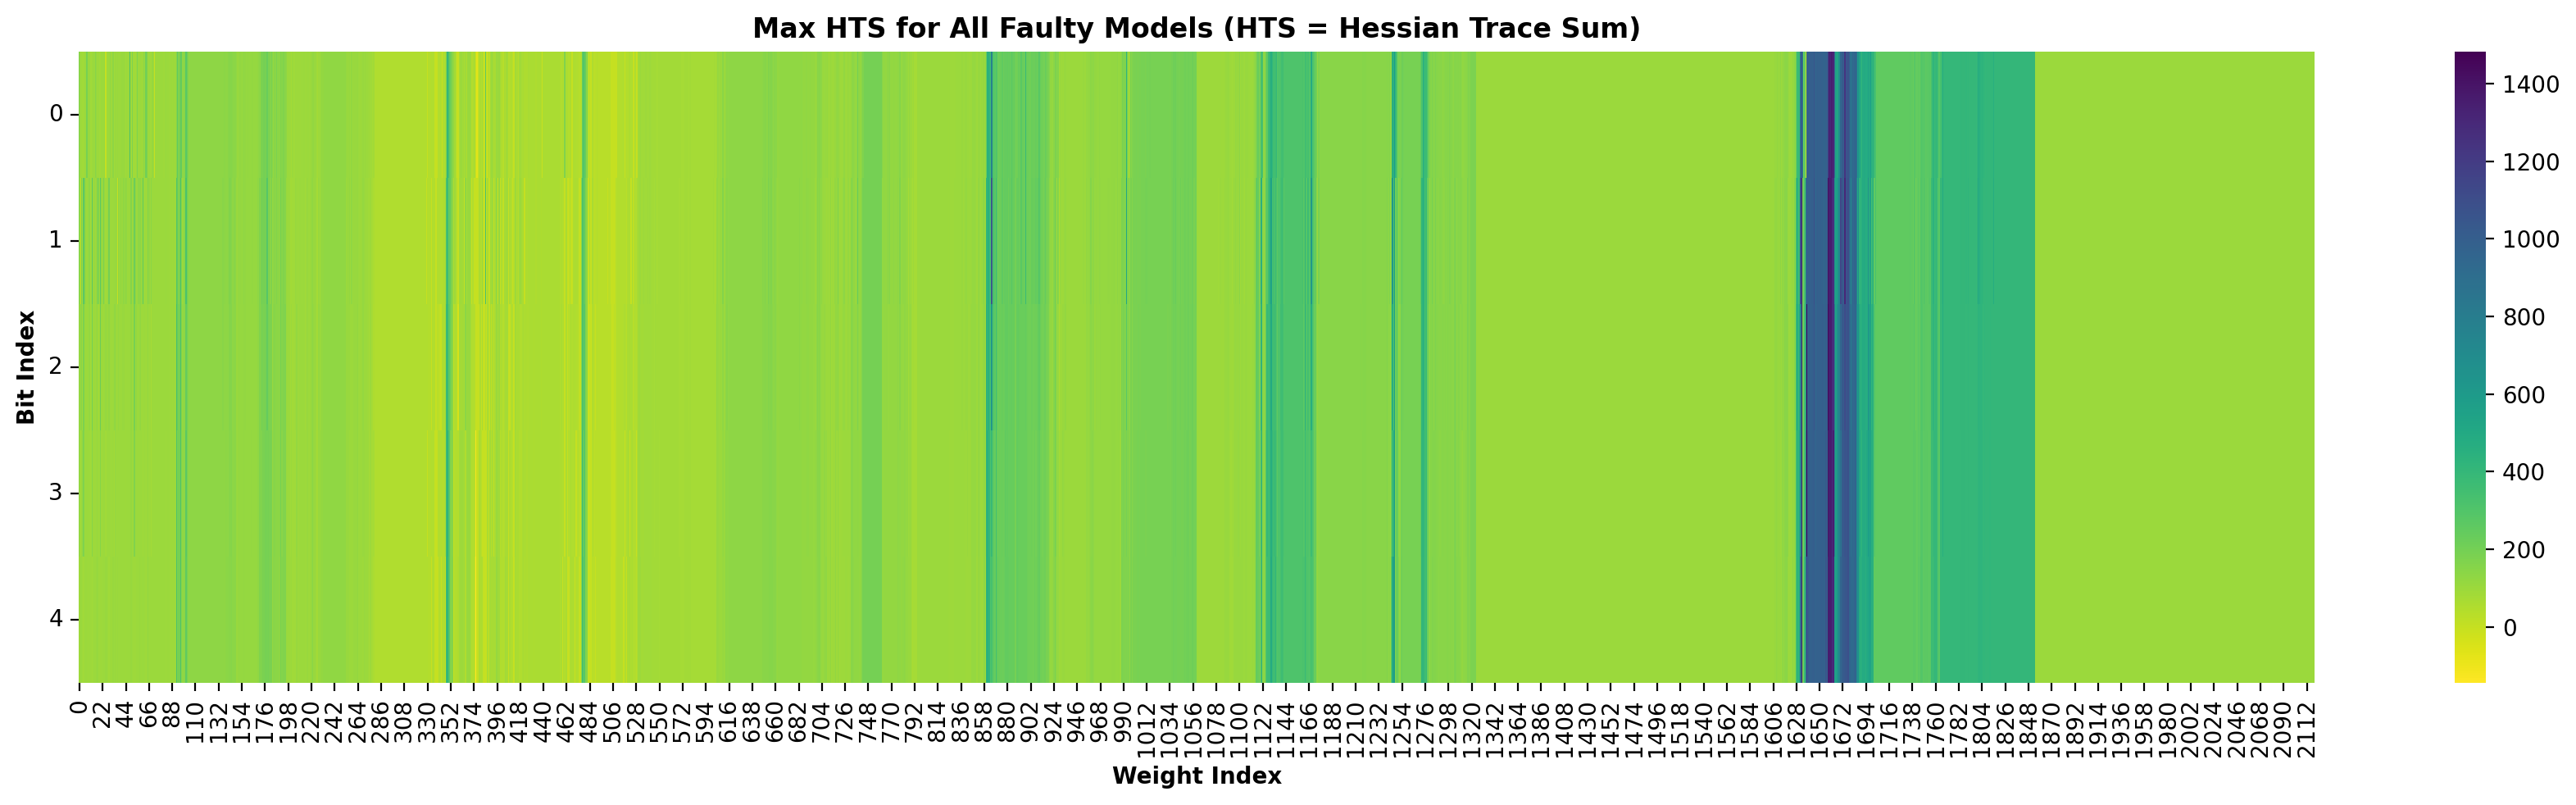

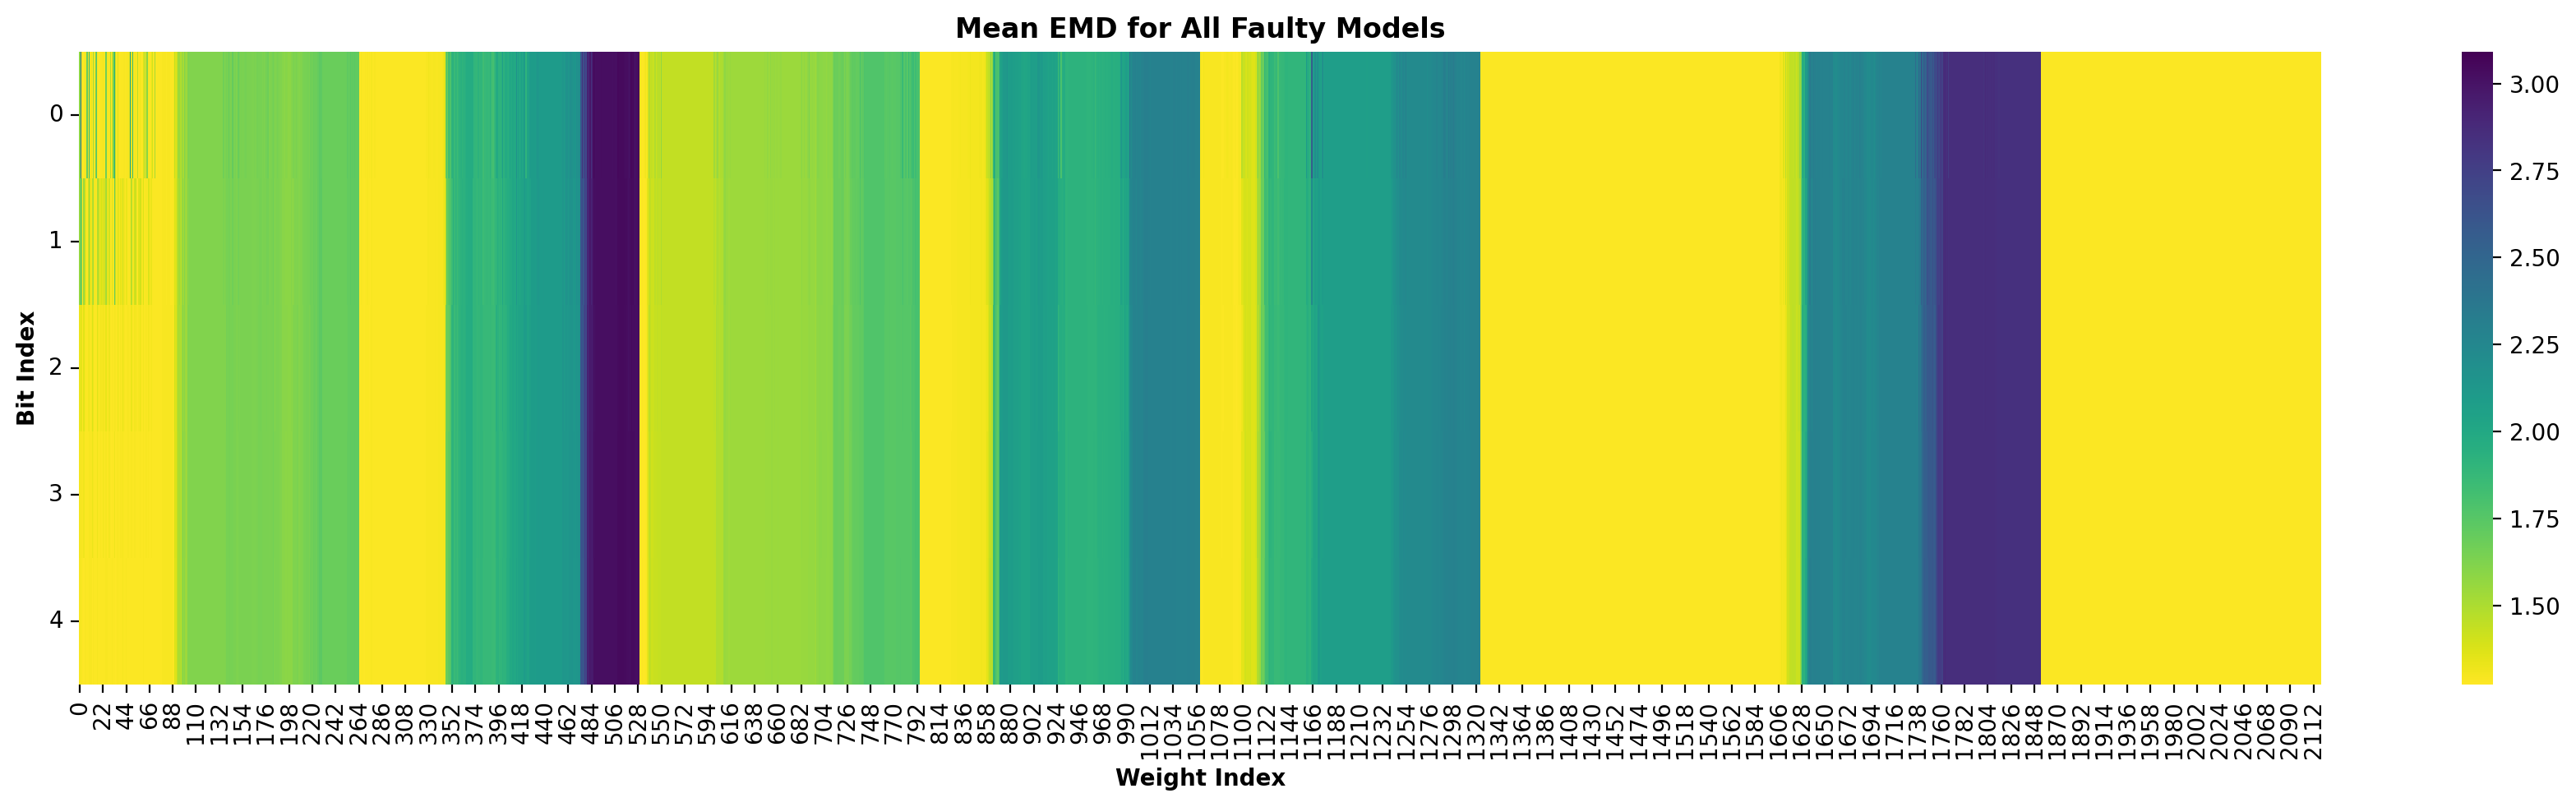

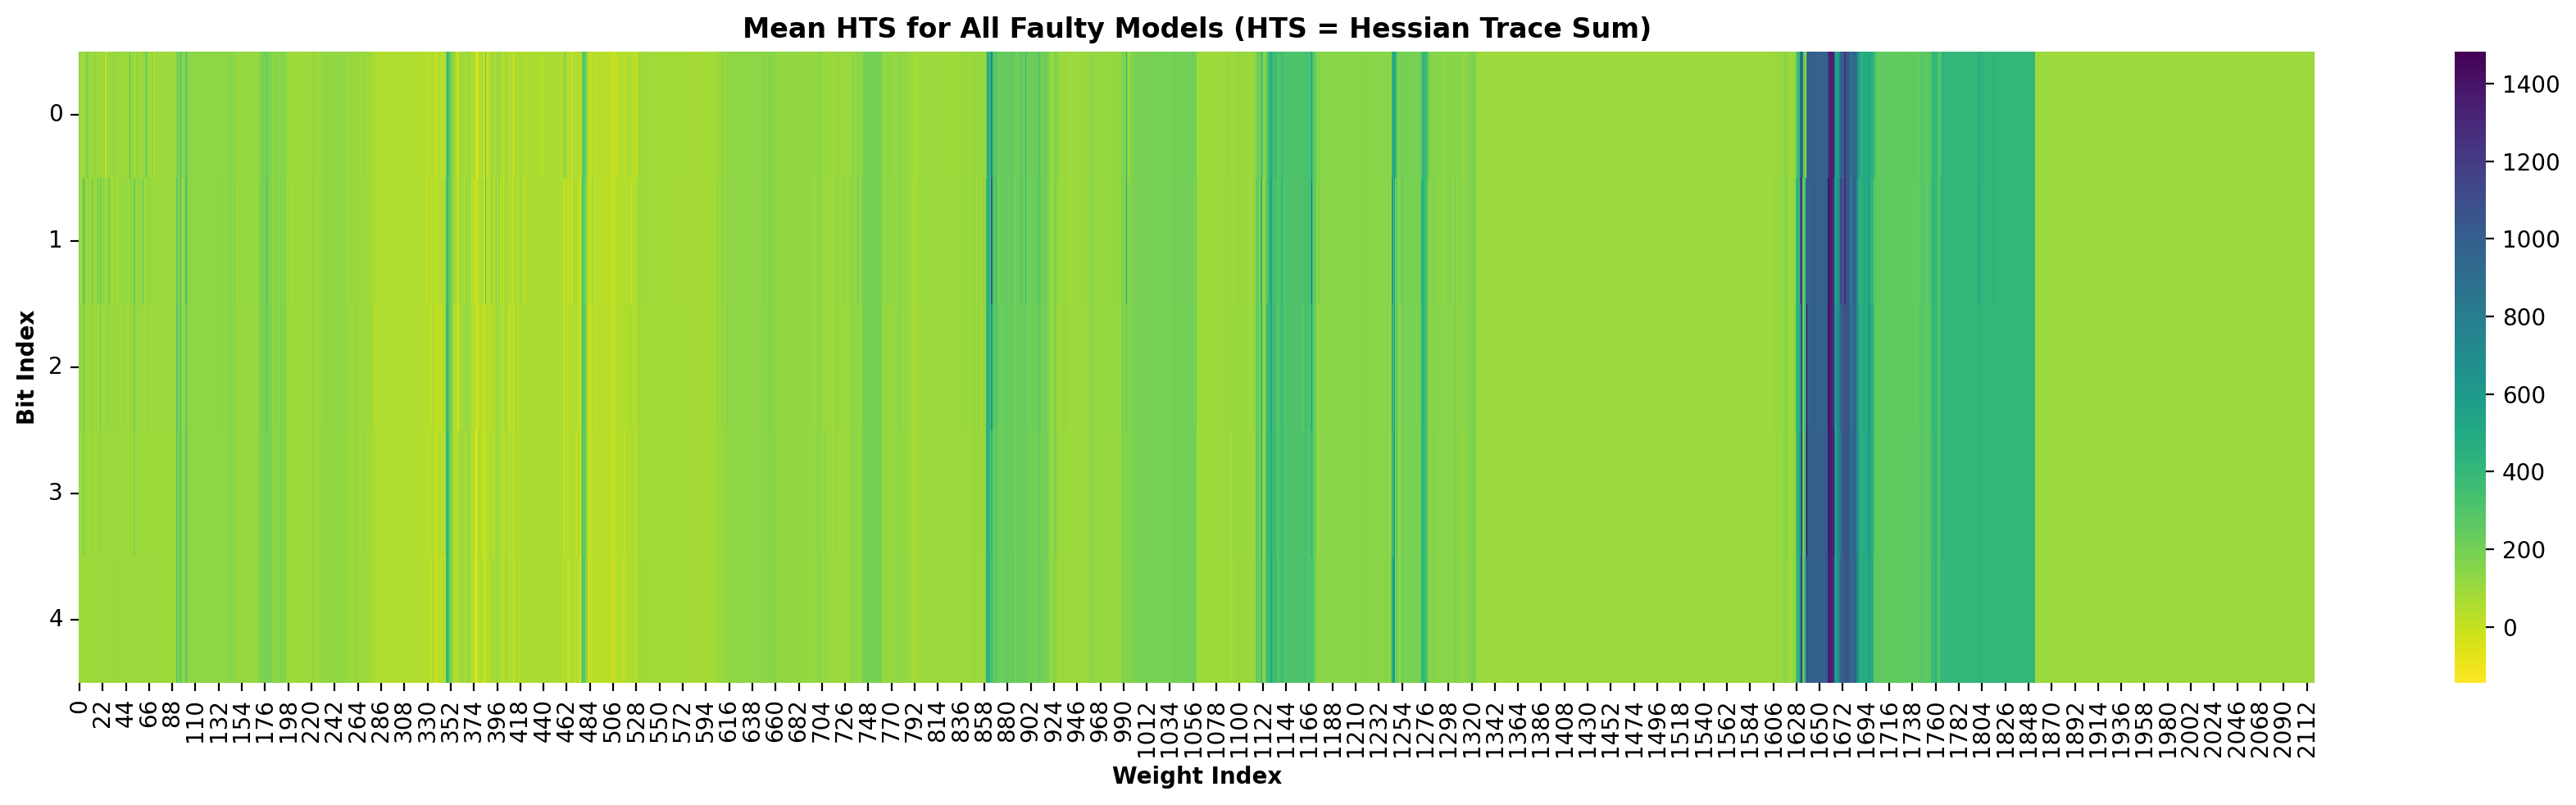

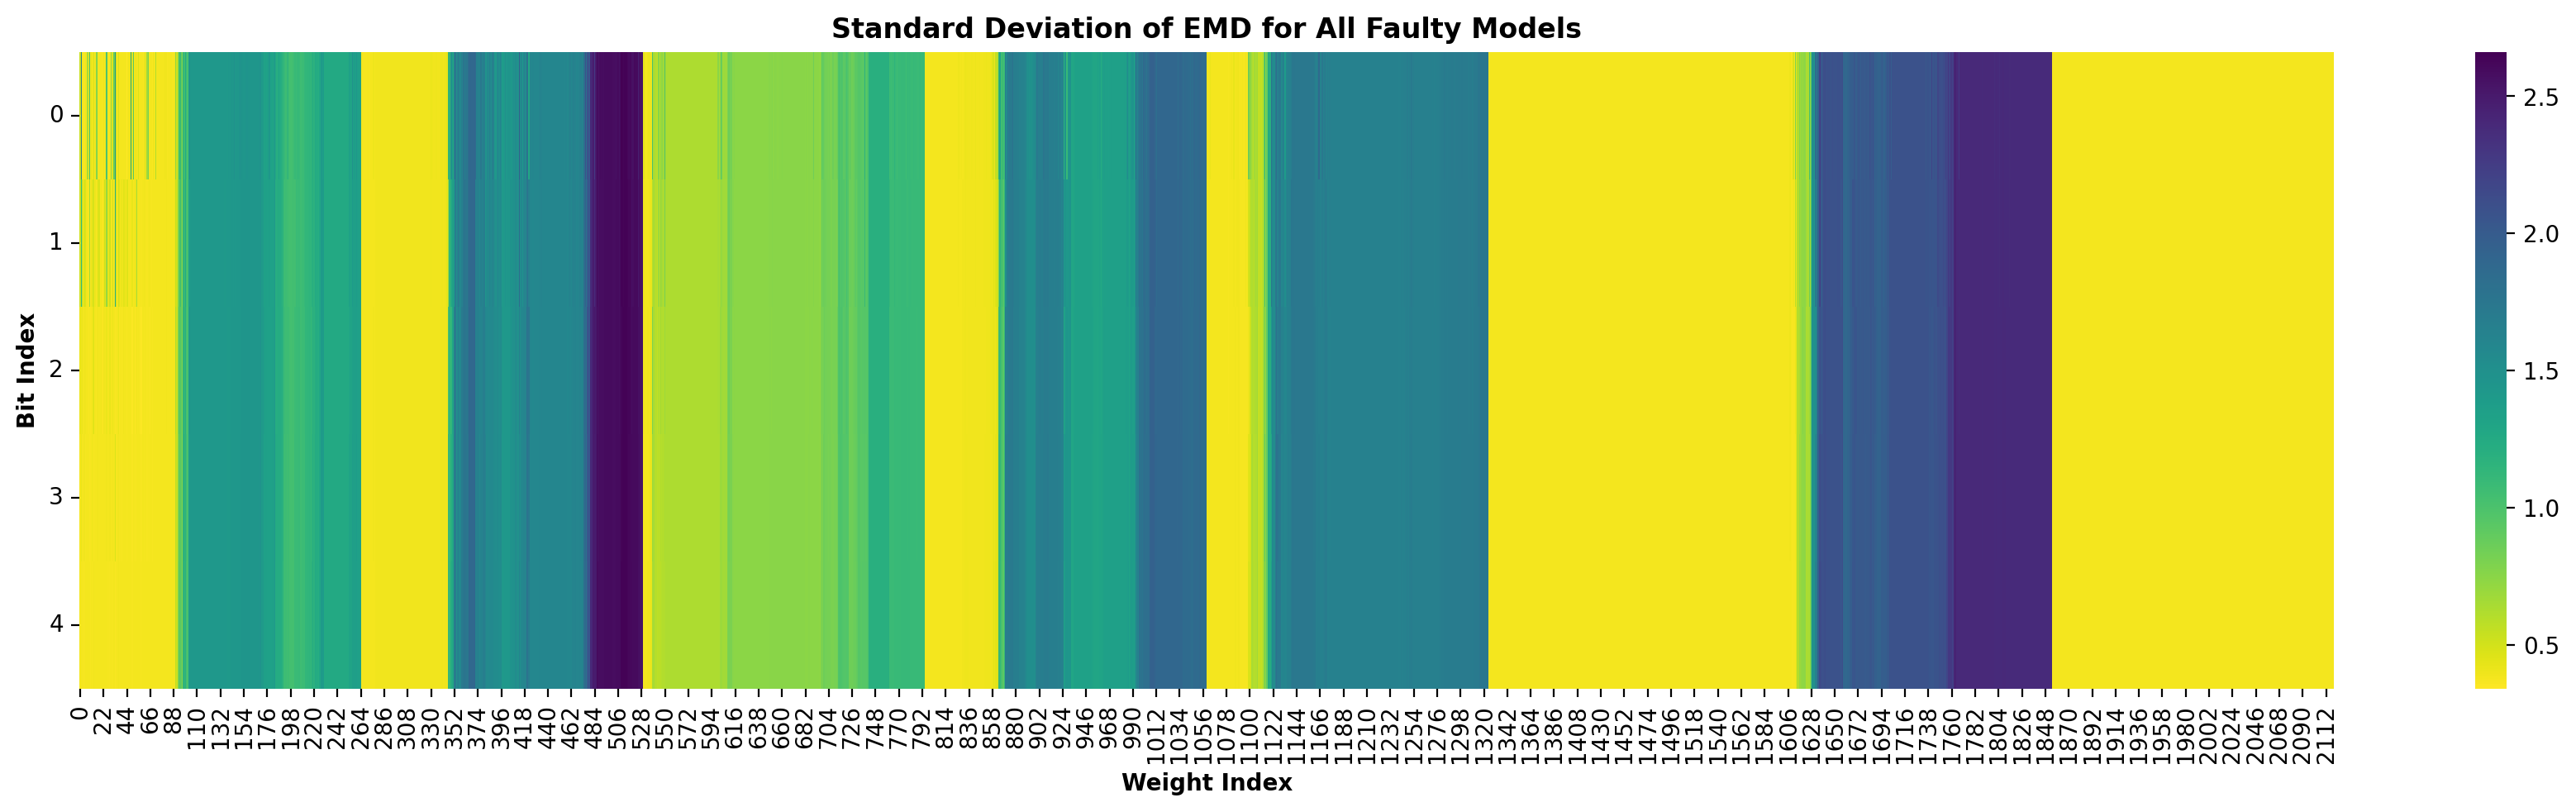

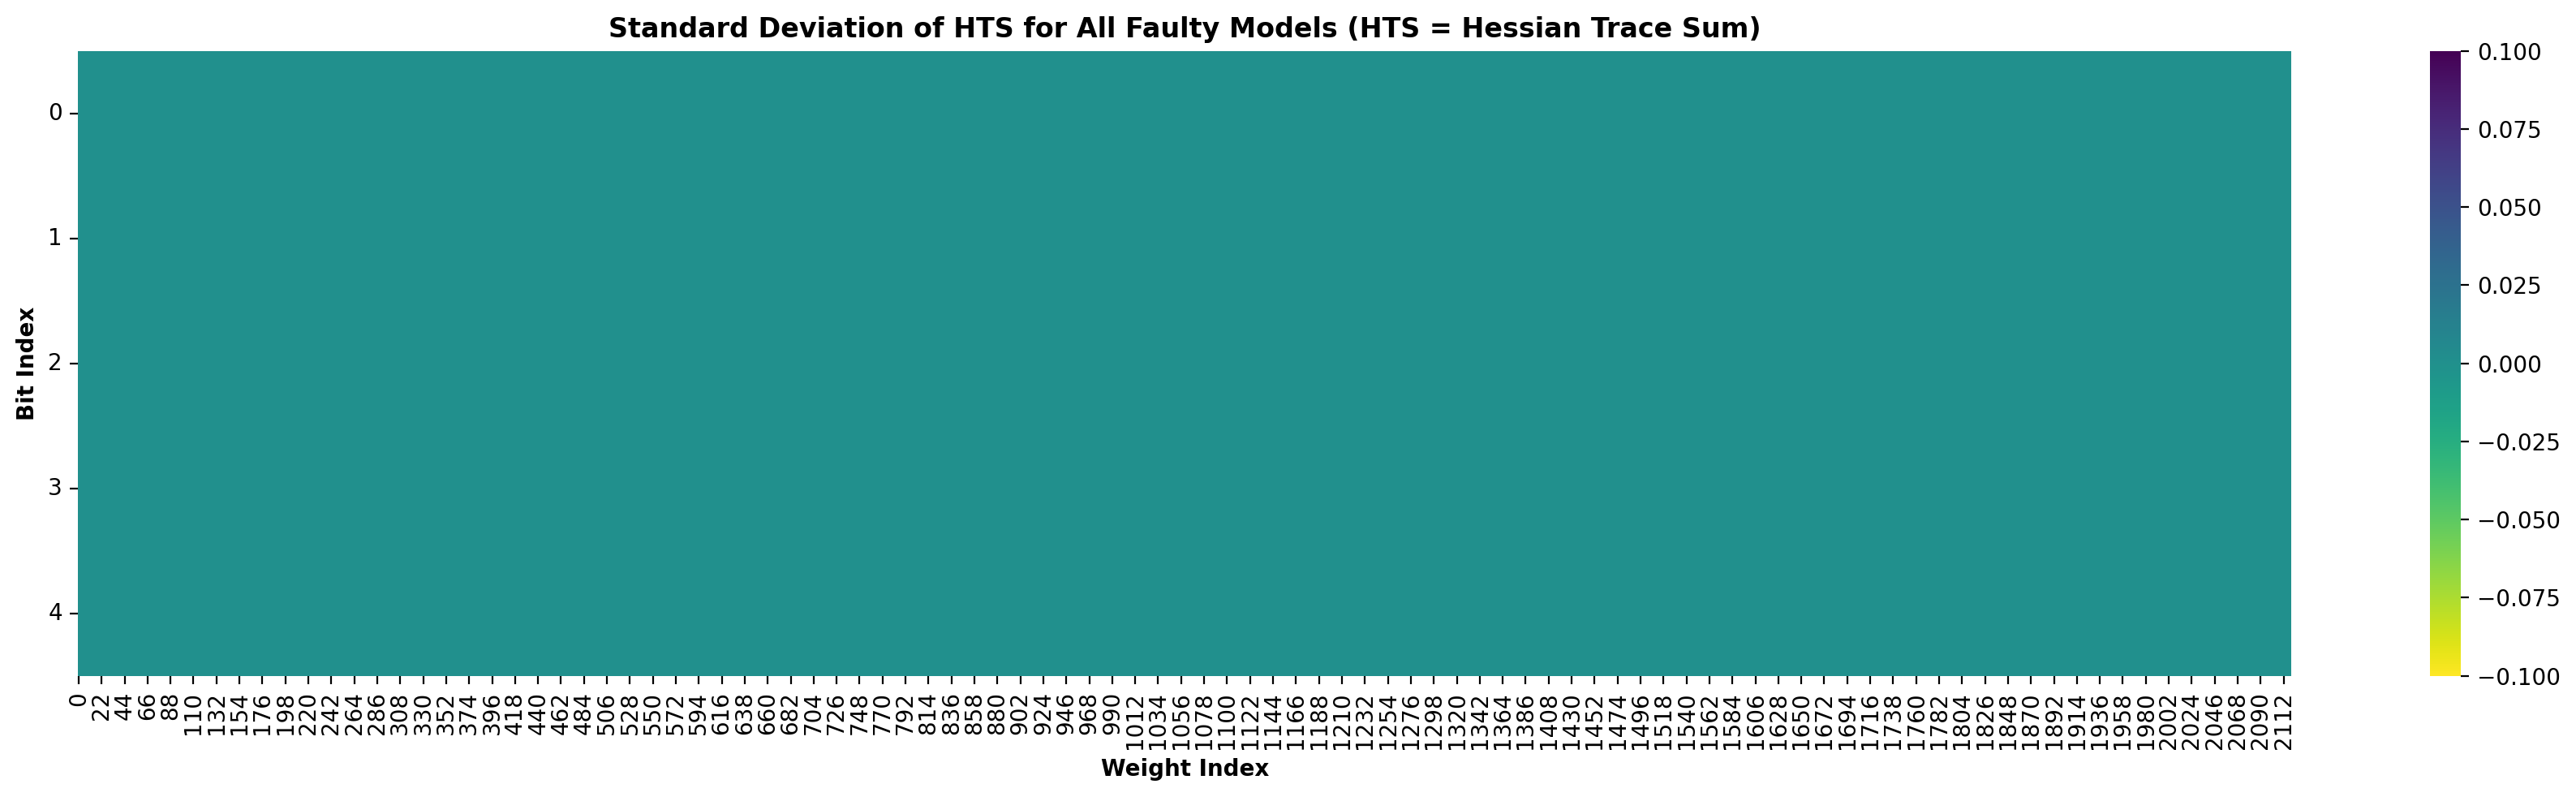

In [8]:
######################################################################
# Example Usage (with correct results from gcloud)                           
######################################################################
#S: Specify num of bits to be flipped, num of val inputs, and num bits in each weight
my_nbits = 10600
my_nvals = 32
my_wbits = 5


#S: Specify the path to an efr file (it can have missing values)
my_efx_files = "/home/anmeza/GitHub/fastml-science/sensor-data-compression/gcloud_results/efx_files_at_2023-03-12_22:44:01"
temp_efd_fp, temp_efr_fp = consolidate_efx_files(my_efx_files, nbits=my_nbits, nVMs=10)
test_efr = temp_efr_fp
test_efr = "/home/anmeza/GitHub/fastml-science/sensor-data-compression/efx_emd_hesstrace_v0-31/efr_emd_hesstrace_v0-31.log"


#S: Parse the efr file. Note that missing EMD and HT values are replaced with a default value
### NOTE: The default values you set here will influence the heatmap coloring (especially if 
### there are a lot of missing values in your EFR file).
my_emd_dflt = 0.0
my_ht_dflt = 0.0
bi_to_EMDs, bi_to_HTs = parse_efr_file(test_efr, nbits=my_nbits, nvals=my_nvals, emd_val_dflt=my_emd_dflt, ht_val_dflt=my_ht_dflt)


#S: Verify certain properties about the parsed EMD and HT values
assert bi_to_EMDs.keys().__len__() == 10600
assert bi_to_HTs.keys().__len__()  == 10600
assert sum([len(EMDs) for EMDs in bi_to_EMDs.values()]) == 32*10600 
assert sum([len(HTs) for HTs in bi_to_EMDs.values()]) == 32*10600


#S: Apply the desired reducing/folding/aggregrating function(s) to EMD and HT values
desired_functions = [
    (np.min    , "Min"                  , "min_buggy_run"),
    (np.max    , "Max"                  , "max_buggy_run"),
    (np.average, "Mean"                 , "mean_buggy_run"),
    (np.std    , "Standard Deviation of", "std_buggy_run"),
]
# desired_functions = [
#     (np.min    , "Min"                  , "min_crrct_run"),
#     (np.max    , "Max"                  , "max_crrct_run"),
#     (np.average, "Mean"                 , "mean_crrct_run"),
#     (np.std    , "Standard Deviation of", "std_crrct_run"),
# ]

for dfunc, title_prefix, save_str in desired_functions:
    bi_to_rEMDs = dict()
    for bi in bi_to_EMDs:
        bi_to_rEMDs[bi] = dfunc(bi_to_EMDs[bi])

    bi_to_rHTs = dict()
    for bi in bi_to_HTs:
        bi_to_rHTs[bi] = dfunc(bi_to_HTs[bi])


    #S: Get intensity matrix/grid for heatmap
    x, y, intensity_EMD = get_hmap_intesity_grid(bi_to_rEMDs, wbits=my_wbits, agmtrc_dflt=0.0)
    x, y, intensity_HT  = get_hmap_intesity_grid(bi_to_rHTs, wbits=my_wbits, agmtrc_dflt=0.0)

    #S: Generate heatmaps from the intensity matrices/grids
    gen_hmap_from_intensity(intensity_EMD, f"{title_prefix} EMD for All Faulty Models",f"example_hmap_{save_str}_EMD.pdf")
    gen_hmap_from_intensity(intensity_HT, f"{title_prefix} HTS for All Faulty Models (HTS = Hessian Trace Sum)", f"example_hmap_{save_str}_HT.pdf")

In [ ]:
######################################################################
# Example Usage (with buggy/accumulating results from gcloud)  
# Useful for qualitative analysis since there are only real
# EMD and HTS values in our plot. The plots for the correct results
# contain solid vertical rectangles/bands of default values since the
# the experiment is still running.                             
######################################################################
#S: Specify num of bits to be flipped, num of val inputs, and num bits in each weight
my_nbits = 10600
my_nvals = 32
my_wbits = 5


#S: Specify the path to an efr file (it can have missing values)
my_efx_files = "/home/anmeza/GitHub/fastml-science/sensor-data-compression/gcloud_results/efx_files_at_2023-03-12_22:44:01"
temp_efd_fp, temp_efr_fp = consolidate_efx_files(my_efx_files, nbits=my_nbits, nVMs=10)
test_efr = temp_efr_fp
test_efr = "/home/anmeza/GitHub/fastml-science/sensor-data-compression/efx_emd_hesstrace_v0-31/efr_emd_hesstrace_v0-31.log"


#S: Parse the efr file. Note that missing EMD and HT values are replaced with a default value
### NOTE: The default values you set here will influence the heatmap coloring (especially if 
### there are a lot of missing values in your EFR file).
my_emd_dflt = 0.0
my_ht_dflt = 0.0
bi_to_EMDs, bi_to_HTs = parse_efr_file(test_efr, nbits=my_nbits, nvals=my_nvals, emd_val_dflt=my_emd_dflt, ht_val_dflt=my_ht_dflt)


#S: Verify certain properties about the parsed EMD and HT values
assert bi_to_EMDs.keys().__len__() == 10600
assert bi_to_HTs.keys().__len__()  == 10600
assert sum([len(EMDs) for EMDs in bi_to_EMDs.values()]) == 32*10600 
assert sum([len(HTs) for HTs in bi_to_EMDs.values()]) == 32*10600


#S: Apply the desired reducing/folding/aggregrating function(s) to EMD and HT values
desired_functions = [
    (np.min    , "Min"                  , "min_buggy_run"),
    (np.max    , "Max"                  , "max_buggy_run"),
    (np.average, "Mean"                 , "mean_buggy_run"),
    (np.std    , "Standard Deviation of", "std_buggy_run"),
]
# desired_functions = [
#     (np.min    , "Min"                  , "min_crrct_run"),
#     (np.max    , "Max"                  , "max_crrct_run"),
#     (np.average, "Mean"                 , "mean_crrct_run"),
#     (np.std    , "Standard Deviation of", "std_crrct_run"),
# ]

for dfunc, title_prefix, save_str in desired_functions:
    bi_to_rEMDs = dict()
    for bi in bi_to_EMDs:
        bi_to_rEMDs[bi] = dfunc(bi_to_EMDs[bi])

    bi_to_rHTs = dict()
    for bi in bi_to_HTs:
        bi_to_rHTs[bi] = dfunc(bi_to_HTs[bi])


    #S: Get intensity matrix/grid for heatmap
    x, y, intensity_EMD = get_hmap_intesity_grid(bi_to_rEMDs, wbits=my_wbits, agmtrc_dflt=0.0)
    x, y, intensity_HT  = get_hmap_intesity_grid(bi_to_rHTs, wbits=my_wbits, agmtrc_dflt=0.0)

    #S: Generate heatmaps from the intensity matrices/grids
    gen_hmap_from_intensity(intensity_EMD, f"{title_prefix} EMD for All Faulty Models",f"example_hmap_{save_str}_EMD.pdf")
    gen_hmap_from_intensity(intensity_HT, f"{title_prefix} HTS for All Faulty Models (HTS = Hessian Trace Sum)", f"example_hmap_{save_str}_HT.pdf")